In [1]:
from typing import TypedDict, Annotated
from langgraph.graph import StateGraph, add_messages, START, END
from langchain_core.messages import AIMessage, HumanMessage
from langgraph.graph import MessagesState
from langchain_tavily import TavilySearch
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import Command, interrupt
from langchain.chat_models import init_chat_model

llm = init_chat_model("ollama:qwen2.5:32b", temperature=0)

In [2]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

tool = TavilySearch(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

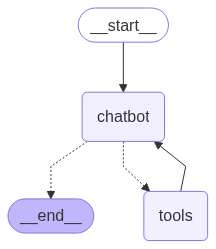

In [4]:
graph

In [5]:
config = {"configurable": {"thread_id": "2"}}
events = graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": (
                    "I'm learning LangGraph. "
                    "Could you do some research on it for me?"
                ),
            },
        ],
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (e2124b0f-76a2-40ae-8b1b-c258537b473f)
 Call ID: e2124b0f-76a2-40ae-8b1b-c258537b473f
  Args:
    query: LangGraph
================================= Tool Message =================================
Name: tavily_search

{"query": "LangGraph", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://github.com/langchain-ai/langgraph", "title": "langchain-ai/langgraph: Build resilient language agents as graphs.", "content": "GitHub - langchain-ai/langgraph: Build resilient language agents as graphs. langchain-ai.github.io/langgraph/ Trusted by companies shaping the future of agents – including Klarna, Replit, Elastic, and more – LangGraph is a low-level orchestration framework for building, managing, and depl

In [6]:
events = graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": (
                    "Ya that's helpful. Maybe I'll "
                    "build an autonomous agent with it!"
                ),
            },
        ],
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Ya that's helpful. Maybe I'll build an autonomous agent with it!
================================== Ai Message ==================================

That sounds like a great project! Building an autonomous agent using LangGraph can be both exciting and rewarding. Here are some steps to get you started:

1. **Understand the Basics**: Make sure you have a good grasp of what LangGraph offers, including its architecture for building stateful agents and how it integrates with other tools in the LangChain ecosystem.

2. **Set Up Your Development Environment**: Follow the setup instructions provided on the [LangGraph GitHub repository](https://github.com/langchain-ai/langgraph) to get your development environment ready.

3. **Start Small**: Begin by building a simple agent that performs a specific task or set of tasks. This will help you understand how different components interact and how state is managed over ti

In [7]:
to_replay = None
for state in graph.get_state_history(config):
    print("Num Messages: ", len(state.values["messages"]), "Next: ", state.next)
    print("-" * 80)
    if len(state.values["messages"]) == 6:
        # We are somewhat arbitrarily selecting a specific state based on the number of chat messages in the state.
        to_replay = state

Num Messages:  6 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  5 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ('__start__',)
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  3 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  2 Next:  ('tools',)
--------------------------------------------------------------------------------
Num Messages:  1 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  0 Next:  ('__start__',)
--------------------------------------------------------------------------------


In [10]:
for state in graph.get_state_history(config):
    print(state)

StateSnapshot(values={'messages': [HumanMessage(content="I'm learning LangGraph. Could you do some research on it for me?", additional_kwargs={}, response_metadata={}, id='838769e5-1c70-4833-a958-5c991b0ff840'), AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen2.5:32b', 'created_at': '2025-07-16T21:46:56.662692Z', 'done': True, 'done_reason': 'stop', 'total_duration': 26092001100, 'load_duration': 15056346500, 'prompt_eval_count': 988, 'prompt_eval_duration': 2673923800, 'eval_count': 23, 'eval_duration': 8356573100, 'model_name': 'qwen2.5:32b'}, id='run--0915b5c5-df14-4a28-bb5a-bbd444ac1840-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'LangGraph'}, 'id': 'e2124b0f-76a2-40ae-8b1b-c258537b473f', 'type': 'tool_call'}], usage_metadata={'input_tokens': 988, 'output_tokens': 23, 'total_tokens': 1011}), ToolMessage(content='{"query": "LangGraph", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://github.com/langc

In [21]:
start_state = list(graph.get_state_history(config))[-2]
start_state

StateSnapshot(values={'messages': [HumanMessage(content="I'm learning LangGraph. Could you do some research on it for me?", additional_kwargs={}, response_metadata={}, id='838769e5-1c70-4833-a958-5c991b0ff840')]}, next=('chatbot',), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0628e5-554f-610e-8000-2151c97b54de'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}, 'thread_id': '2'}, created_at='2025-07-16T21:46:30.499355+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0628e5-554c-6804-bfff-475d22bc907d'}}, tasks=(PregelTask(id='dfa43fee-18eb-aebd-78da-d5de135591a8', name='chatbot', path=('__pregel_pull', 'chatbot'), error=None, interrupts=(), state=None, result={'messages': [AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen2.5:32b', 'created_at': '2025-07-16T21:46:56.662692Z', 'done': True, 'done_reason': 'stop', 'total_duration': 26092001100, 'load_duration': 15056

In [22]:
to_replay = start_state

In [23]:
# The `checkpoint_id` in the `to_replay.config` corresponds to a state we've persisted to our checkpointer.
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (bb911ca4-00f0-4723-a884-47c036e0b155)
 Call ID: bb911ca4-00f0-4723-a884-47c036e0b155
  Args:
    query: LangGraph
================================= Tool Message =================================
Name: tavily_search

{"query": "LangGraph", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://github.com/langchain-ai/langgraph", "title": "langchain-ai/langgraph: Build resilient language agents as graphs.", "content": "GitHub - langchain-ai/langgraph: Build resilient language agents as graphs. langchain-ai.github.io/langgraph/ Trusted by companies shaping the future of agents – including Klarna, Replit, Elastic, and more – LangGraph is a low-level orchestration framework for building, managing, and depl

In [24]:
for state in graph.get_state_history(config):
    print("Num Messages: ", len(state.values["messages"]), "Next: ", state.next)
    print("-" * 80)

Num Messages:  4 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  3 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  2 Next:  ('tools',)
--------------------------------------------------------------------------------
Num Messages:  6 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  5 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ('__start__',)
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  3 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  2 Next:  ('tools',)
---------------------------------------------------

In [32]:
message_list = graph.get_state(config).values["messages"]

In [35]:
for message in message_list:
    message.pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (bb911ca4-00f0-4723-a884-47c036e0b155)
 Call ID: bb911ca4-00f0-4723-a884-47c036e0b155
  Args:
    query: LangGraph
================================= Tool Message =================================
Name: tavily_search

{"query": "LangGraph", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://github.com/langchain-ai/langgraph", "title": "langchain-ai/langgraph: Build resilient language agents as graphs.", "content": "GitHub - langchain-ai/langgraph: Build resilient language agents as graphs. langchain-ai.github.io/langgraph/ Trusted by companies shaping the future of agents – including Klarna, Replit, Elastic, and more – LangGraph is a low-level orchestration framework for building, managing, and depl